In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# Check Broken Rotor Data

In [2]:
from src.utils.data_utils import RotorDataset

train_dataset = RotorDataset('train', p=0.0015, snr=None, seed=0)
test_dataset = RotorDataset('test', p=1, snr=None, seed=0)

train dataset size:14680, labeled:22, unlabeled:14658
labels : [0:3, 1:5, 2:2, 3:4, 4:8]
test dataset size:3400, labeled:3400, unlabeled:0
labels : [0:680, 1:680, 2:680, 3:680, 4:680]


In [3]:
from torch.utils.data import DataLoader
temp_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

X shape :  torch.Size([1, 12, 2048])
Ground-truth label :  0
Is this label available during training? :  False


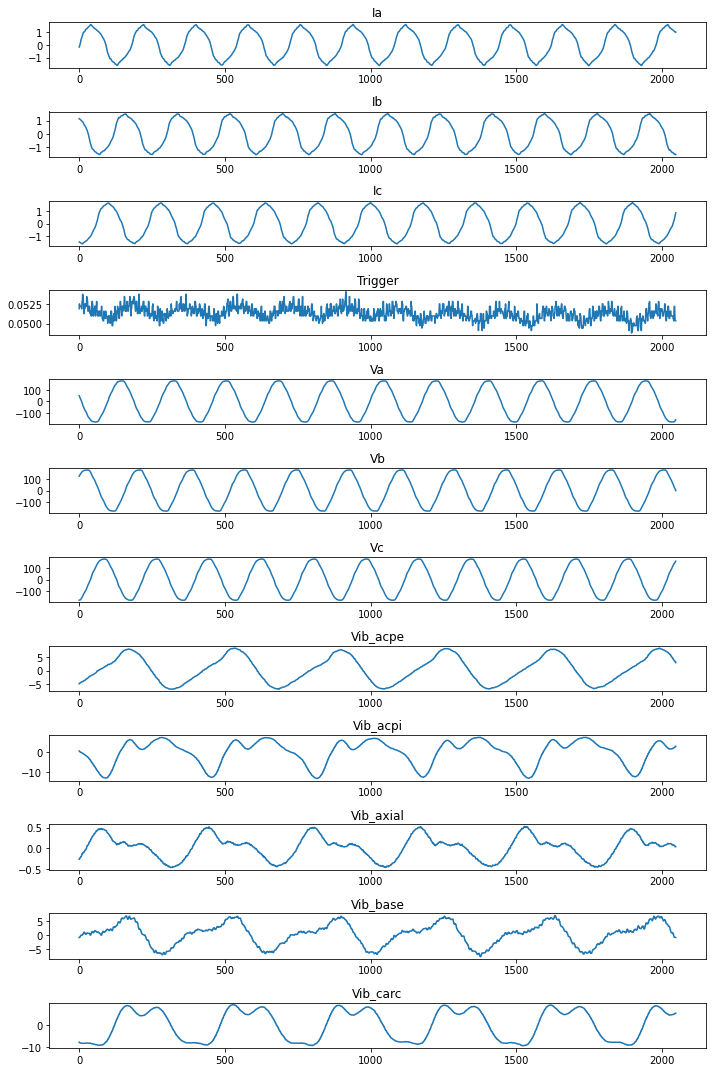

In [4]:
Y = 0
assert Y in [0,1,2,3,4]

Nametags = ['Ia','Ib','Ic','Trigger','Va','Vb','Vc','Vib_acpe','Vib_acpi','Vib_axial','Vib_base','Vib_carc']
while True:
    X, y, M = next(iter(temp_loader))
    if y == Y:
        break
print("X shape : ", X.shape)
print("Ground-truth label : ", y.item())
print("Is this label available during training? : ", M.item())
fig=plt.figure(figsize=(10,15))
for i in range(X.shape[1]):
    ax = plt.subplot(X.shape[1],1,i+1)
    ax.plot(X[0,i])
    #ax.set_ylabel("%s"%Nametags[i])
    ax.set_title("%s"%Nametags[i])
plt.tight_layout()
plt.show()

In [5]:
lb = train_dataset.lb
ub = train_dataset.ub
print(lb.shape, ub.shape)

for i in range(12):
    lower_boundary = lb[i]
    upper_boundary = ub[i]
    print('[%d]  %.4f  ~  %.4f'%(i, lower_boundary, upper_boundary))

(12,) (12,)
[0]  -2.4250  ~  2.4333
[1]  -2.4958  ~  2.5000
[2]  -2.4708  ~  2.4667
[3]  0.0369  ~  0.0891
[4]  -176.9000  ~  176.9500
[5]  -176.5000  ~  176.7917
[6]  -175.7000  ~  175.6417
[7]  -12.8326  ~  17.4377
[8]  -17.6941  ~  10.2112
[9]  -0.7355  ~  0.7935
[10]  -25.3967  ~  31.1676
[11]  -22.5067  ~  26.0834


# Model Architectures for Signal Data

In [6]:
from src.skeleton import BaseModel

class WDCNN(BaseModel):
    def __init__(self, in_dim, h_dims=[16,32,64,64,64], out_dim=5, model_name='wdcnn'):
        super().__init__(model_name=model_name)
        self.conv1 = self._conv_block(in_dim, h_dims[0], 64, 16, 24)
        self.conv2 = self._conv_block(h_dims[0], h_dims[1], 3, 1, 1)
        self.conv3 = self._conv_block(h_dims[1], h_dims[2], 3, 1, 1)
        self.conv4 = self._conv_block(h_dims[2], h_dims[3], 3, 1, 1)
        self.conv5 = self._conv_block(h_dims[3], h_dims[4], 3, 1, 0)
        self.fc = nn.Linear(h_dims[4], out_dim)
        
    def _conv_block(self, in_dim, out_dim, k, s, p):
        return nn.Sequential(
            nn.Conv1d(in_dim, out_dim, kernel_size=k, stride=s, padding=p, bias=False),
            nn.BatchNorm1d(out_dim),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.ReLU()
        )
    
    def forward(self, batch, label=None, mask=None):
        x = self.conv1(batch)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        z = x.mean(-1)
        
        x = self.fc(z)
        
        return x
    
    def get_z(self, batch, label=None, mask=None):
        x = self.conv1(batch)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        z = x.mean(-1)
        
        return z

In [7]:
model = WDCNN(in_dim=12, h_dims=[4,4,4,4,4], out_dim=5)

X,y,M = next(iter(temp_loader))
with torch.no_grad():
    X = X.to(dtype=torch.float)
    pred = model(X,y,M)
print(pred.shape)

torch.Size([1, 5])


# Perturbation

In [8]:
def perturb_snr(data, snr=10):
    snr1 = 10**(snr/10.0)
    #xpower = np.sum(data**2, axis=-1) / data.shape[-1]
    xpower = (data**2).sum(-1) / data.shape[-1]
    npower = xpower/snr1
    noise = torch.randn(*data.shape, device=data.device) * torch.sqrt(npower).unsqueeze(-1)
    noise_data = data+noise
    return noise_data

def perturb_crop(data, step=1, side='l'):
    if side == 'l':
        return data[..., step:]
    elif side == 'r':
        return data[..., :-step]

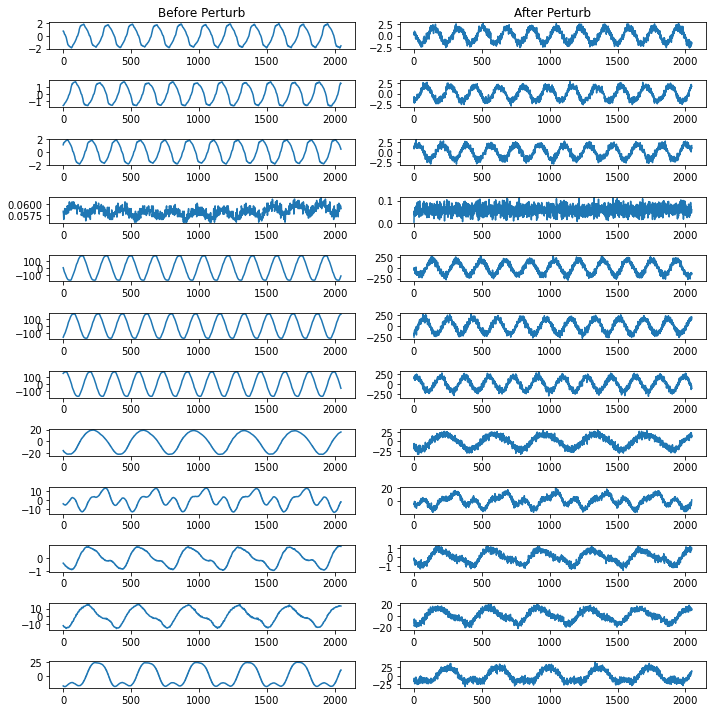

In [9]:
X,y,M = next(iter(temp_loader))
X_perturb_snr = perturb_snr(X, snr=10)

fig=plt.figure(figsize=(10,10))
for i in range(X.shape[1]):
    ax = plt.subplot(X.shape[1],2,2*i+1)
    ax.plot(X[0,i])
    ax2 = plt.subplot(X.shape[1],2,2*i+2)
    ax2.plot(X_perturb_snr[0,i])
    if i==0 :
        ax.set_title('Before Perturb')
        ax2.set_title('After Perturb')
plt.tight_layout()
plt.show()

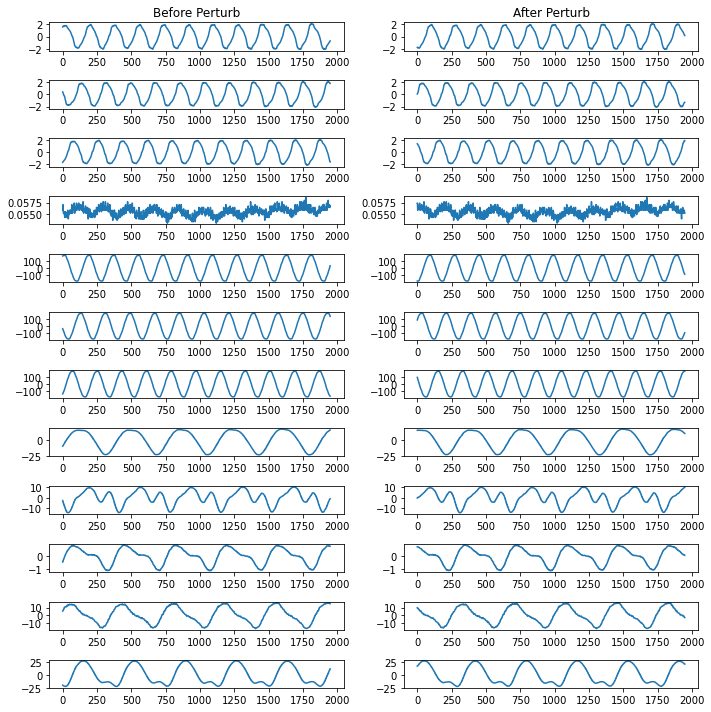

In [10]:
X,y,M = next(iter(temp_loader))
X_perturb_crop = perturb_crop(X, step=100, side='l')
X = perturb_crop(X, step=100, side='r')


fig=plt.figure(figsize=(10,10))
for i in range(X.shape[1]):
    ax = plt.subplot(X.shape[1],2,2*i+1)
    ax.plot(X[0,i])
    ax2 = plt.subplot(X.shape[1],2,2*i+2)
    ax2.plot(X_perturb_crop[0,i])
    if i==0 :
        ax.set_title('Before Perturb')
        ax2.set_title('After Perturb')
plt.tight_layout()
plt.show()